# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1, Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import os, imp

Text(0.5,1,'diff')

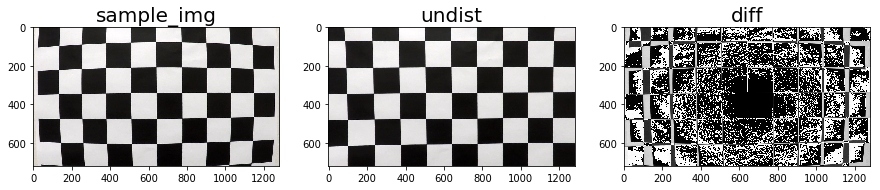

In [2]:
def camera_calibration():
    """
    Calibrate the camera with chessboard images shot 
    by the camera in different distence or angels
    """
    nx = 9
    ny = 6

    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    objpoints = []
    imgpoints = []
    
    cal_images = glob.glob('camera_cal/cal*.jpg')
    for idx, image in enumerate(cal_images):
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # find chessboard coeners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret :
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(100)
    cv2.destroyAllWindows()
    
    sample_img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (sample_img.shape[0], sample_img.shape[1])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    # Save the mtx and dist data for further use
    pickle.dump(dist_pickle, open('camera_cal/dist_pickle.p', 'wb'))

# The camera need be calibrated only by once.
if os.path.isfile('camera_cal/dist_pickle.p') == False :
    camera_calibration()
else:
    # load the calibration file
    dist_pickle = pickle.load(open('camera_cal/dist_pickle.p', 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    
    
## Show the image before and after the undistort, as well as the difference
sample_img = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(sample_img, mtx, dist, None, mtx)
#Show the difference in grayscale
diff = cv2.cvtColor(sample_img,cv2.COLOR_RGB2GRAY) - cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)

f, axs = plt.subplots(1, 3, figsize=(15,15))
axs[0].imshow(sample_img)
axs[0].set_title('sample_img', fontsize=20)

axs[1].imshow(undist)
axs[1].set_title('undist', fontsize=20)

axs[2].imshow(diff, cmap='gray')
axs[2].set_title('diff', fontsize=20)

As we can see, the farther the pixel is away from the center, the worse the distortion.

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

The goal of this procedure is to seprate the lane line pixels from the original image.

s: False grad: False r: True v: True


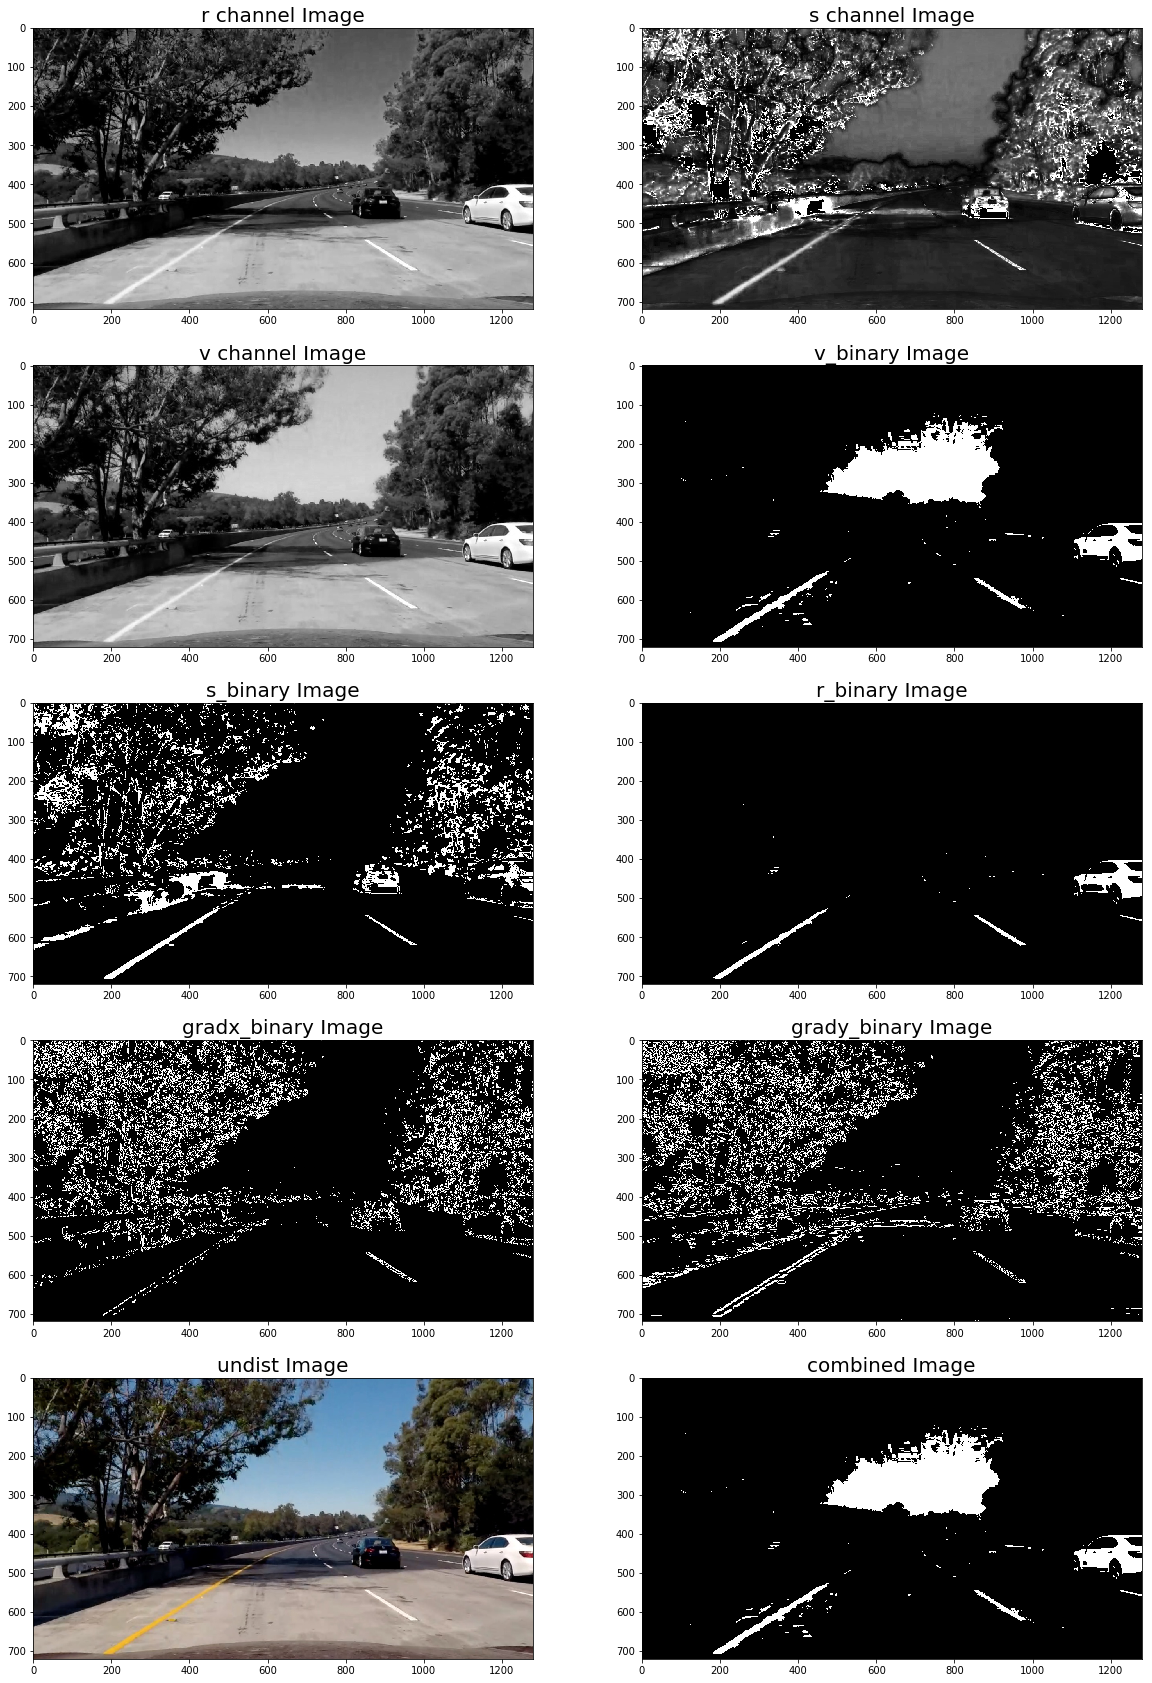

In [3]:
# I write the image preprocessing functions in 'Preprocessing.py'
# Include: 
    # abs_sobel_thresh
    # warper
    # abs_sobel_thresh
    # mag_thresh
    # dir_threshold
    # color_channel_threshold
    # preprocessing_image

from Preprocessing import *

def test(img_path):
    global a, b,c
    #  This function contains some of the thresholds methods 
    #  I tried to seperate the lane lines
    
    img = mpimg.imread(img_path)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert image into different color maps
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(undist, cv2.COLOR_RGB2HSV)
    # Separate the color channels
    s = hls[:,:,2]
    l = hls[:,:,1]
    h = hls[:,:,0]
    r = undist[:,:,0]
    g = undist[:,:,1]
    b = undist[:,:,2]
    v = hsv[:,:,2]
    # threholds methrods
    gradx_binary = abs_sobel_thresh(s, 'x', (25,100))
    grady_binary = abs_sobel_thresh(s, 'y', (25,100))  
    dir_binary = dir_threshold(gray, sobel_kernel=11, threshold=(1.2, 1.3))
    mag_binary = mag_thresh(gray, sobel_kernel=3, threshold=(30, 255))
    s_binary = color_channel_threshold(s, (130, 255))
    r_binary = color_channel_threshold(r, (210, 255))
    bottom_v_mean = int(np.mean(v[v.shape[0]//2:,:]))
    v_binary = color_channel_threshold(v, (200, 255))
    
    #------------
    # To make sure that the threshold image is reasonable
    s_ok = np.sum(s_binary[360:,:]) < 30000
    grad_ok = np.sum(gradx_binary[360:,:]) < 30000
    r_ok = np.sum(r_binary[360:,:]) < 30000
    v_ok = np.sum(v_binary[360:,:]) < 30000    
    print('s:',s_ok, 'grad:',grad_ok, 'r:',r_ok, 'v:',v_ok)
    #------------    
    combined = np.zeros_like(r)
    combined[(s_binary*s_ok==1) | (gradx_binary*grad_ok==1) | (r_binary*r_ok==1) | (v_binary*v_ok==1)] = 1
    a = s_binary
    b = gradx_binary
    # show the images
    f, axs = plt.subplots(5, 2, figsize=(20,30))
    axs[0, 0].imshow(r, cmap='gray')
    axs[0, 0].set_title('r channel Image', fontsize=20)

    axs[0, 1].imshow(s, cmap='gray')
    axs[0, 1].set_title('s channel Image', fontsize=20)

    axs[1, 0].imshow(v, cmap='gray')
    axs[1, 0].set_title('v channel Image', fontsize=20)

    axs[1, 1].imshow(v_binary, cmap='gray')
    axs[1, 1].set_title('v_binary Image', fontsize=20)

    axs[2, 0].imshow(s_binary, cmap='gray')
    axs[2, 0].set_title('s_binary Image', fontsize=20)

    axs[2, 1].imshow(r_binary, cmap='gray')
    axs[2, 1].set_title('r_binary Image', fontsize=20);
   
    axs[3, 0].imshow(gradx_binary, cmap='gray')
    axs[3, 0].set_title('gradx_binary Image', fontsize=20);
    
    axs[3, 1].imshow(grady_binary, cmap='gray')
    axs[3, 1].set_title('grady_binary Image', fontsize=20);

    axs[4, 0].imshow(undist)
    axs[4, 0].set_title('undist Image', fontsize=20);

    axs[4, 1].imshow(combined, cmap='gray')
    axs[4, 1].set_title('combined Image', fontsize=20);

# Test the func in different images
test_images = glob.glob('test_images/*.jpg')    

test(test_images[6])
#test('project_video_frames/frame1047.jpg')

## 3.Apply a perspective transform to rectify binary image ("birds-eye view").

The transform need 4 pixels' coordinates in the source and destination images. I chose them manually form the image with straight lane lines.

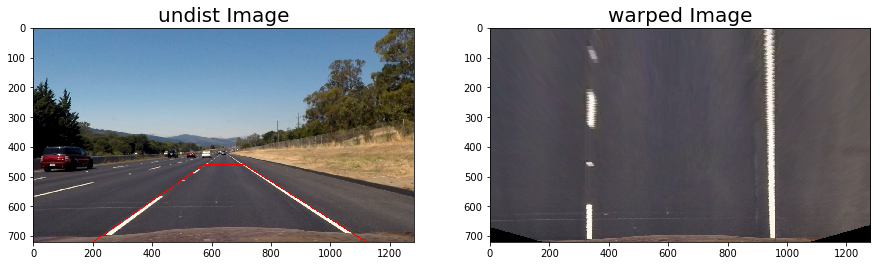

In [4]:
# Manually selected pixels
src =np.float32([[575, 460],
                [200, 720],
                [1120, 720],
                [710, 460]])
img_size = [sample_img.shape[1], sample_img.shape[0]]

dst = np.float32([[img_size[0]/4, 0],
                [img_size[0]/4, img_size[1]],
                [img_size[0]/4*3, img_size[1]],
                [img_size[0]/4*3, 0]])


img = mpimg.imread(test_images[1])
undist = cv2.undistort(img, mtx, dist, None, mtx)
warped = warper(undist, src, dst)

cv2.line(undist, tuple(src[0]), tuple(src[1]), (255,0,0),2)
cv2.line(undist, tuple(src[2]), tuple(src[3]), (255,0,0),2)
cv2.line(undist, tuple(src[0]), tuple(src[3]), (255,0,0),2)

cv2.line(warped, tuple(dst[0]), tuple(dst[1]), (255,0,0),2)
cv2.line(warped, tuple(dst[2]), tuple(dst[3]), (255,0,0),2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(undist)
ax1.set_title('undist Image', fontsize=20);
ax2.imshow(warped)
ax2.set_title('warped Image', fontsize=20);

## 4.Detect lane pixels and fit to find the lane boundary.

I write the detection code in the 'LaneLines.py'. It contains a lane finding class.

In [5]:
%reload_ext autoreload
%autoreload 2
from LaneLines import Line
from Preprocessing import *

In [6]:
num = 1
for image in test_images:
    
    lane = Line()
    original_img = cv2.imread(image)
    original_img = cv2.undistort(original_img, mtx, dist)
    warped_binary = preprocessing_image(original_img, mtx, dist, src, dst)
    original_img = cv2.undistort(original_img, mtx, dist)
#     if lane.detected == True:
#         lane.search_around_poly(warped_binary, margin = 100)
#     else:
    lane.sliding_windows(warped_binary)
    lane.fit_polynomial()
    out = lane.output(original_img, src ,dst)
    cv2.imwrite('output_images/'+str(num)+'.jpg', out)
    num += 1
    #print(lane.frame_num, lane.diffs)
    

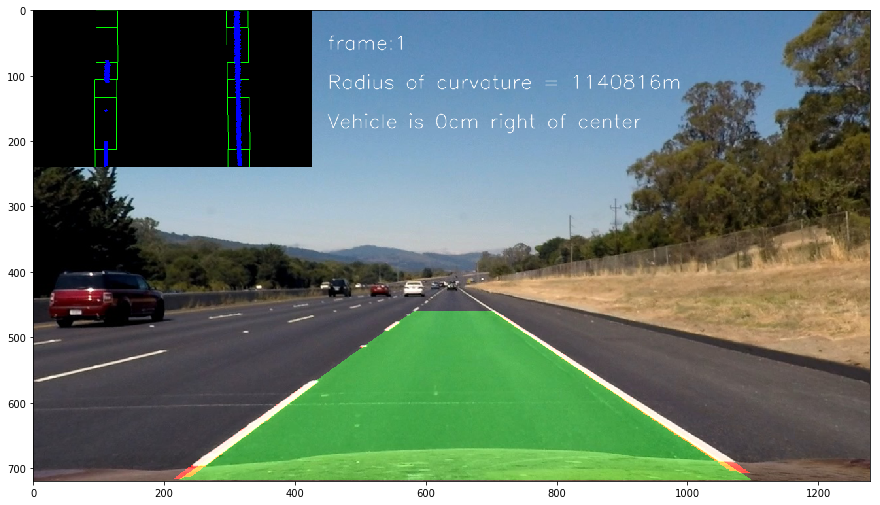

In [7]:
# Here is a example of one test image processed.
original = mpimg.imread(test_images[1])
original = cv2.undistort(original, mtx, dist)
warped_binary = preprocessing_image(original, mtx, dist, src, dst)

warped_binary1 = preprocessing_image(original, mtx, dist, src, dst)
lane= Line(src, dst)
lane.sliding_windows(warped_binary)
lane.fit_polynomial()

#lane.search_around_poly(warped_binary)

out = lane.output(original, src, dst)
plt.figure( figsize=(15,10))
plt.imshow(out);

In [8]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    warped_binary = preprocessing_image(image, mtx, dist, src, dst)
    
    lane.sliding_windows(warped_binary)
    lane.fit_polynomial()
    out = lane.output(undist, src, dst)

    return out

Let's try the one with the solid white lane on the right first ...

In [11]:
lane= Line()
output = 'output_videos/project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_images/project_video.mp4")
challenge_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(output, audio=False);

Moviepy - Building video output_videos/project_video_out.mp4.
Moviepy - Writing video output_videos/project_video_out.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_out.mp4
Wall time: 5min 30s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [13]:
lane= Line()
challenge_output = 'output_videos/challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False);

Moviepy - Building video output_videos/challenge_video_out.mp4.
Moviepy - Writing video output_videos/challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video_out.mp4
Wall time: 2min 1s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [15]:
lane= Line()
challenge_output = 'output_videos/harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
challenge_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False);

Moviepy - Building video output_videos/harder_challenge_video_out.mp4.
Moviepy - Writing video output_videos/harder_challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready output_videos/harder_challenge_video_out.mp4
Wall time: 5min 28s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))